In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [24]:
path = './lfw/lfw'

In [25]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [26]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")


CUDA device is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


torch.Size([250, 250, 3])


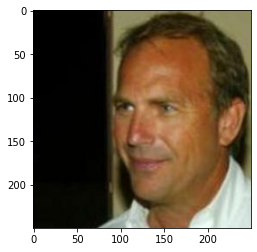

In [28]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

The dimensions of the Input image torch.Size([3, 250, 250]) represent the following:

3: This is the number of channels in the image. For a standard color image, this typically corresponds to the RGB color model, meaning there are three channels for red, green, and blue, respectively.

250: The first 250 represents the height of the image in pixels. It is the number of pixel rows in the image.

250: The second 250 represents the width of the image in pixels. It is the number of pixel columns in the image.

So, in summary:

The first dimension (3) indicates that the image is in color (RGB).
The second and third dimensions (250, 250) give the spatial resolution of the image, indicating it is 250 pixels high and 250 pixels wide.






# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(16)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(32)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2)

        # Decoder layers
        self.decoder_conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(16)

        self.decoder_conv2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = self.encoder_pool1(x)
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = self.encoder_pool2(x)
        return x
        
    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample to 124x124
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))

        x = F.interpolate(x, size=(250, 250), mode='nearest')  # Upsample to 250x250
        x = torch.sigmoid(self.decoder_bn2(self.decoder_conv2(x)))  # Sigmoid activation for the last layer
        
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


If the loss in my autoencoder is not decreasing, I would first adjust the learning rate because an inappropriate rate is often the cause of poor training progress. Next, I'd check the optimizer settings and perhaps try a different optimizer like Adam for better convergence. If those don't work, I'd look at the model architecture to ensure it's suitable for the complexity of the data and consider implementing regularization techniques to prevent overfitting. It's also crucial to verify that the data preprocessing is correct, particularly that the images are normalized.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [30]:
# Create an instance of the AutoEncoder class
autoencoder = AE().to(device)

# Get a sample image from the dataloader
sample_image, _ = next(iter(dataloader))
sample_image = sample_image.to(device)

# Checking the shape of the input image
print("Input Image Shape:", sample_image.shape)

# Passing the sample image through the encoder
encoder_output = autoencoder.encoder(sample_image)

# Checking the shape of the encoder output
print("Encoder Output Shape:", encoder_output.shape)

# Pass the encoder output through the decoder
decoder_output = autoencoder.decoder(encoder_output)

# Checking the shape of the decoder output
print("Decoder Output Shape:", decoder_output.shape)


Input Image Shape: torch.Size([32, 3, 250, 250])
Encoder Output Shape: torch.Size([32, 32, 62, 62])
Decoder Output Shape: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [31]:
model = AE().to(device)  # Instantiating model
total_params = sum(p.numel() for p in model.parameters())
print("Total Number of Parameters: {}".format(total_params))

Total Number of Parameters: 10281


In [32]:
import torch.optim as optim

learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
loss_function = torch.nn.MSELoss();

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [34]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_data in dataloader:  # dataloader contains training data
        optimizer.zero_grad()  # Zero the gradients
        input_data = batch_data[0].to(device)  # Moving input data to the device (CPU/GPU)

        # Forward pass
        output_data = model(input_data)

        # Calculate loss (MSE in this case)
        loss = torch.nn.MSELoss()(output_data, input_data)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # You can add validation and early stopping logic here

print("Training finished.")


Epoch [1/5] - Loss: 0.0145
Epoch [2/5] - Loss: 0.0050
Epoch [3/5] - Loss: 0.0029
Epoch [4/5] - Loss: 0.0021
Epoch [5/5] - Loss: 0.0018
Training finished.


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

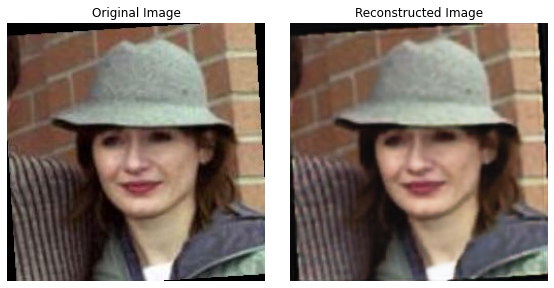

In [35]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the dataset
random_index = random.randint(0, len(dataset) - 1)
input_image, _ = dataset[random_index]

# Pass the input image through the model to get the reconstructed image
with torch.no_grad():
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image.to(device)  # Move to the appropriate device
    reconstructed_image = model(input_image)

# Convert tensors to NumPy arrays for visualization
input_image = input_image.squeeze(0).cpu().numpy()
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()

# Plot the original and reconstructed images side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image.transpose(1, 2, 0))  # Transpose to (H, W, C) format
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.transpose(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

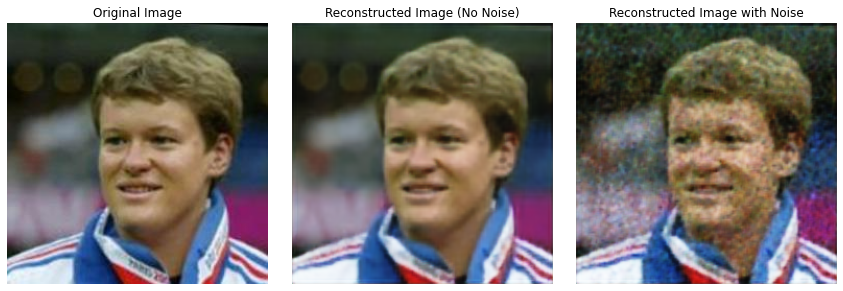

In [41]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms


# Select a random image from the dataset
random_index = random.randint(0, len(dataset) - 1)
input_image, _ = dataset[random_index]

# Pass the input image through the model to get the latent representation
with torch.no_grad():
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image.to(device)  # Move to the appropriate device
    latent_representation = model.encoder(input_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.3  # Adjusting the noise scale as needed
noisy_representation = latent_representation + noise

# Decode the noisy latent representation
with torch.no_grad():
    noisy_reconstructed_image = model.decoder(noisy_representation.to(device))

# Convert tensors to NumPy arrays for visualization, making sure to detach them
input_image_np = input_image.squeeze(0).cpu().detach().numpy()
reconstructed_image = model.decoder(latent_representation.to(device))  # Decoding the original latent representation
reconstructed_image_np = reconstructed_image.squeeze(0).cpu().detach().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).cpu().detach().numpy()

# Ensure pixel values are within the valid range [0, 1]
input_image_np = input_image_np.clip(0, 1)
reconstructed_image_np = reconstructed_image_np.clip(0, 1)
noisy_reconstructed_image_np = noisy_reconstructed_image_np.clip(0, 1)

# Plot the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image (No Noise)")
plt.imshow(reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image with Noise")
plt.imshow(noisy_reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()


When noise was added to the latent representation with a scale factor of 0.3, it significantly disrupted the information encoded in the latent space. As a result, the decoded image shows noticeable artifacts and distortions.

In the noisy reconstructed image, you can observe that the features such as the face, hair, and background are less distinct and more blurred compared to the reconstructed image without noise. This blurring is due to the decoder trying to reconstruct the image from a latent space that has been altered by the addition of noise. The greater the noise, the more the original encoded features are perturbed, leading to a loss of detail and clarity in the reconstructed image.

This experiment illustrates the impact of noise on the autoencoder's ability to reconstruct images accurately. It demonstrates the sensitivity of the model to changes in the latent space and can be indicative of the model's robustness. If the noise level were lower, the model might have been able to reconstruct an image closer to the original. However, with a noise level of 0.3, the disruption is severe enough to cause significant visual degradation.